In [1]:
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
# import dask
# import dask.distributed
# import ncar_jobqueue
import esmlab
import esmlab_regrid
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from netCDF4 import default_fillvals
import pop_tools 

import config

import warnings
from datetime import date, datetime, timezone


### Prep work
set up directory with original and destination grid files in it

In [2]:
USER = os.environ['USER']
gridfile_directory = esmlab.config.set({'regrid.gridfile-directory': f'/glade/work/{USER}/esmlab-regrid'})
esmlab.config.get('regrid.gridfile-directory')

'/glade/work/kristenk/esmlab-regrid'

In [3]:
method = 'conservative'
src_grid = 'latlon_1x1_180W'
dst_grid = 'POP_gx1v7'
ltripole = False

regrid_operator = esmlab_regrid.regridder(name_grid_src=src_grid, 
                                          name_grid_dst=dst_grid, 
                                          method=method, overwrite_existing=False)

/glade/work/kristenk/esmlab-regrid
/glade/work/kristenk/esmlab-regrid


In [4]:
ds_dst = pop_tools.get_grid(grid_name=dst_grid)
ds_dst

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 2.339e+06 2.339e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    TAREA        (nlat, nlon) float64 1.39e+13 1.39e+13 ... 7.431e+12 7.432e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0

### Define a dictionary to translate variable names from GLODAP to POP and set up file paths

In [5]:
glodap_pth = '/glade/work/kristenk/GLODAPv2_regridded/*.nc'
pop_to_glodap_vars = {'ALK': 'TAlk'} #,'NO3':'NO3',} #just doing ALK for now.... 

In [6]:
glodap_to_pop_vars = {glodap: pop for pop, glodap in pop_to_glodap_vars.items()}

### Use the function to get GLODAP data

In [7]:
ds_glodap = xr.open_dataset('/glade/work/kristenk/GLODAPv2_regridded/TAlk_GLODAP_normal1deg_33depths.nc',decode_times=False,decode_coords=False)
#ds_glodap = xr.open_mfdataset('/glade/work/kristenk/GLODAPv2_regridded/*.nc',decode_times=False,decode_coords=False)
ds_glodap = ds_glodap.rename({k: v for k, v in glodap_to_pop_vars.items() if k in ds_glodap.data_vars})
ds_glodap = ds_glodap.drop('TAlkInput_mean')
ds_glodap = ds_glodap.rename({'depth_surface': 'depth'})
ds_glodap

<xarray.Dataset>
Dimensions:  (depth: 33, lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * depth    (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Data variables:
    ALK      (depth, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        tmp2.nc
    history:      grdmath tmp2.nc land_mask1deg.nc OR = CESM1-BGC_Jan1850_tos.nc
    GMT_version:  4.5.12 [64-bit]
    node_offset:  1

In [8]:
ds_glodap['ALK'].attrs

OrderedDict([('long_name', 'total alkalinity'), ('units', 'micromol kg-1')])

In [9]:
varlist = ['ALK']

In [10]:
for pop_varname in varlist:
    attrs = ds_glodap[pop_varname].attrs
    
    if pop_varname == 'ALK' and attrs['units'] == 'micromol kg-1':
        ds_glodap[pop_varname] = ds_glodap[pop_varname] * 1.027 #convert from micromol/kg to mmol/m3
        attrs['units'] = 'mmol/m^3'
        
    ds_glodap[pop_varname].attrs = attrs

### Regrid laterally

/glade/work/kristenk/miniconda/envs/analysis2/lib/python3.7/site-packages/esmlab_regrid/core.py:203: RuntimeWarning: invalid value encountered in greater
  data_dst = np.where(ones_dst > 0.0, data_dst, np.nan)


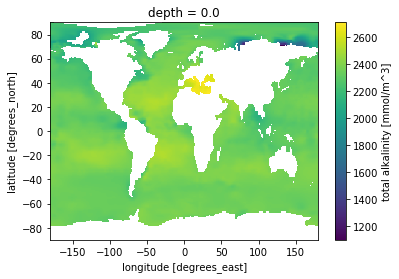

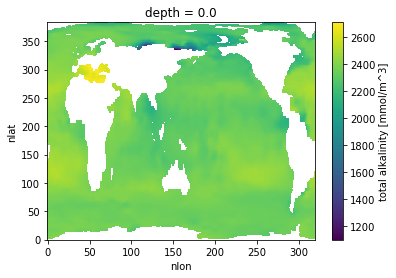

In [11]:
dso_lateral = xr.Dataset()
for v in varlist:
    dso_lateral[v] = regrid_operator(ds_glodap[v], renormalize=True)  #, apply_mask=True) #commented out apply_mask (get an error)
    dso_lateral[v].attrs = ds_glodap[v].attrs

dso_lateral = dso_lateral.rename({'lon': 'nlon', 'lat': 'nlat'})

dso_lateral.depth.data = dso_lateral.depth.data * 1e2
dso_lateral.depth.attrs['units'] = 'cm'

plt.figure()
ds_glodap[varlist[0]].isel(depth=0).plot()

plt.figure()
dso_lateral[varlist[0]].isel(depth=0).plot();

In [13]:
dso_lateral

<xarray.Dataset>
Dimensions:  (depth: 33, nlat: 384, nlon: 320)
Coordinates:
  * depth    (depth) float64 0.0 1e+03 2e+03 3e+03 ... 4.5e+05 5e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    ALK      (depth, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan

In [14]:
dso_lateral.depth

<xarray.DataArray 'depth' (depth: 33)>
array([     0.,   1000.,   2000.,   3000.,   5000.,   7500.,  10000.,  12500.,
        15000.,  20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,
        80000.,  90000., 100000., 110000., 120000., 130000., 140000., 150000.,
       175000., 200000., 250000., 300000., 350000., 400000., 450000., 500000.,
       550000.])
Coordinates:
  * depth    (depth) float64 0.0 1e+03 2e+03 3e+03 ... 4.5e+05 5e+05 5.5e+05
Attributes:
    long_name:  depth
    units:      cm
    positive:   down

In [17]:
ds_dst.z_t

<xarray.DataArray 'z_t' (z_t: 60)>
array([5.000000e+02, 1.500000e+03, 2.500000e+03, 3.500000e+03, 4.500000e+03,
       5.500000e+03, 6.500000e+03, 7.500000e+03, 8.500000e+03, 9.500000e+03,
       1.050000e+04, 1.150000e+04, 1.250000e+04, 1.350000e+04, 1.450000e+04,
       1.550000e+04, 1.650984e+04, 1.754790e+04, 1.862913e+04, 1.976603e+04,
       2.097114e+04, 2.225783e+04, 2.364088e+04, 2.513702e+04, 2.676542e+04,
       2.854837e+04, 3.051192e+04, 3.268680e+04, 3.510935e+04, 3.782276e+04,
       4.087847e+04, 4.433777e+04, 4.827367e+04, 5.277280e+04, 5.793729e+04,
       6.388626e+04, 7.075633e+04, 7.870025e+04, 8.788252e+04, 9.847059e+04,
       1.106204e+05, 1.244567e+05, 1.400497e+05, 1.573946e+05, 1.764003e+05,
       1.968944e+05, 2.186457e+05, 2.413972e+05, 2.649001e+05, 2.889385e+05,
       3.133405e+05, 3.379794e+05, 3.627670e+05, 3.876452e+05, 4.125768e+05,
       4.375393e+05, 4.625190e+05, 4.875083e+05, 5.125028e+05, 5.375000e+05])
Coordinates:
  * z_t      (z_t) float64 

### Regrid vertically

In [18]:
dso_lat_vert = xr.Dataset()

dim = 'depth'
new_coord = ds_dst.z_t
for v in varlist:
    da = dso_lateral[v]
    dso_lat_vert[v] = da.interp(coords={dim: new_coord},
                                method='linear',
                                assume_sorted=True,
                                kwargs={'bounds_error': False})
    dso_lat_vert[v] = xr.where(np.isclose(dso_lat_vert[v], 0., atol=1e-10), 0., 
                               dso_lat_vert[v])
    dso_lat_vert[v].attrs = dso_lateral[v].attrs
    
dso_lat_vert = dso_lat_vert.drop([dim])
dso_lat_vert

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    ALK      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan

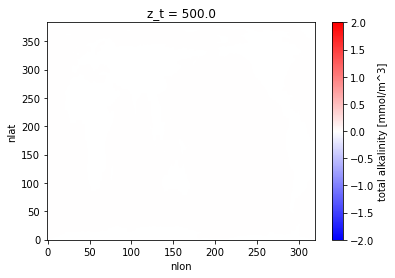

In [28]:
#just double check that the vertical interpolation worked
diff = dso_lat_vert.ALK.isel(z_t=0) - dso_lateral.ALK.isel(depth=slice(0,2)).mean(dim='depth')
diff.plot(vmin=-2,vmax=2,cmap='bwr')

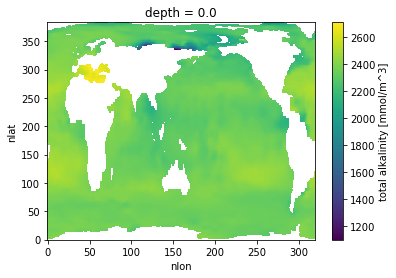

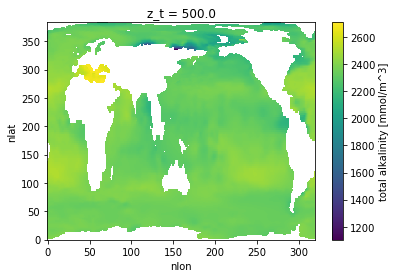

In [29]:
plt.figure()
dso_lateral[varlist[-1]].isel(depth=0).plot()

plt.figure()
dso_lat_vert[varlist[-1]].isel(z_t=0).plot();

### Apply missing values mask to the newly interpolated data
First make a mask

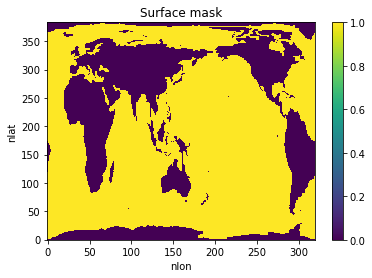

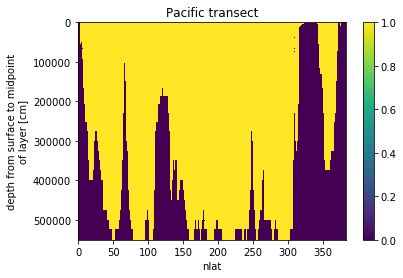

In [30]:
nk = len(ds_dst.z_t)
nj, ni = ds_dst.KMT.shape

# make 3D array of 0:km
zero_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'))
ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))
ZERO_TO_KM = (zero_to_km * ONES_3d)

# mask out cells where k is below KMT
MASK = ZERO_TO_KM.where(ZERO_TO_KM < ds_dst.KMT)
MASK = xr.where(MASK.notnull(), True, False)

MASK['z_t'] = ds_dst.z_t

plt.figure()
MASK.isel(z_t=0).plot()
h = plt.title('Surface mask')

plt.figure()
MASK.isel(nlon=200).plot(yincrease=False)
h = plt.title('Pacific transect')


Then apply the mask

In [31]:
for v in varlist:   
    dso_lat_vert[v] = dso_lat_vert[v].where(MASK)

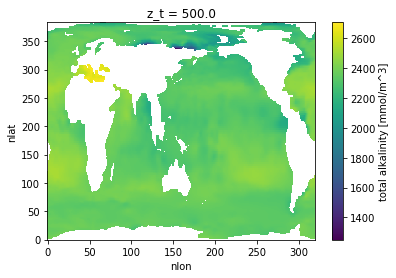

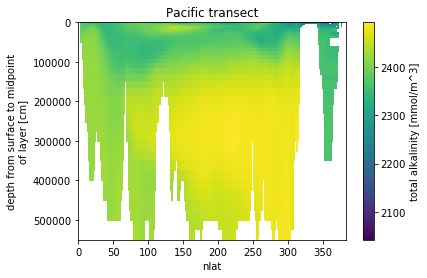

In [32]:
plt.figure()
dso_lat_vert[varlist[0]].isel(z_t=0).plot()

plt.figure()
dso_lat_vert[varlist[0]].isel(nlon=200).plot(yincrease=False)
h = plt.title('Pacific transect')

### Lateral smoothing operation

In [58]:
# loop over variables
dso_smooth = xr.Dataset()
for v in varlist:    
    
    # apply lateral smooth
    dso_smooth[v] = pop_tools.lateral_fill(dso_lat_vert[v].copy(), MASK, ltripole=ltripole)
    dso_smooth[v].attrs = dso_lat_vert[v].attrs
    
    # perform vertical fill if necessary
    unfilled = dso_smooth[v].isnull() & (MASK == 1.)                    
    if not unfilled.any():
        continue   
    for k in range(1, ds_dst.z_t.shape[0]):
        dso_smooth[v][k, :, :] = xr.where(unfilled[k, :, :], 
                                          dso_smooth[v][k-1, :, :], 
                                          dso_smooth[v][k, :, :])
        
    if (dso_smooth[v].isnull() & (MASK == 1.)).any():
        warnings.warn(f'{v} still has missing values')
    
dso_smooth

/glade/work/kristenk/miniconda/envs/analysis2/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: ALK still has missing values


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    ALK      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan

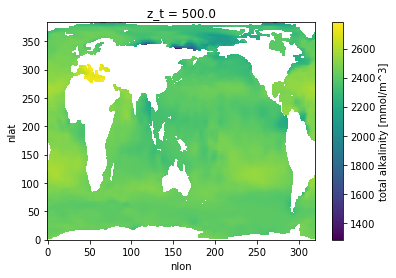

In [59]:
dso_smooth.ALK.isel(z_t=0).plot() # I don't think I'll use this since there's data where there were nans in glodap

### Get the dataset ready to write out

In [34]:
#dso = dso_smooth.copy()
dso = dso_lat_vert.copy()
for v in dso.variables:
    dso[v].encoding['_FillValue'] = default_fillvals['f4']
    dso[v].encoding['dtype'] = np.float32
    if dso.ALK.dims == {'z_t', 'nlat', 'nlon'}:
        dso[v].attrs['coordinates'] = 'TLONG TLAT z_t'
    
for v in ds_dst.variables:
    dso[v] = ds_dst[v]
    
for v in dso.variables:
    if '_FillValue' not in dso[v].encoding:
        dso[v].encoding['_FillValue'] = None
    
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
dso.attrs['history'] = f'created by kristen krumhardt on {datestamp}'

datestamp = date.today().strftime("%y%m%d")
dso

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    ALK          (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 2.339e+06 2.339e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    TAREA        (nlat, nlon) float64 1.39e+13 1.39e+1

In [35]:
file_out = '/glade/work/kristenk/GLODAPv2_regridded/glodap_pop_grid/GLODAP_POPgrid_v2.nc'
dso.to_netcdf(file_out)